In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import datetime as dt
from IPython.display import HTML
import os
plt.rcParams['animation.ffmpeg_path'] = '../ffmpeg.exe'

In [22]:
class Params():
    def __init__(self):
        self.pop_size = 500
        self.age_mean = 46
        self.age_std = 13
        self.age_min = 0
        self.age_max = 99
        
        self.colors = ["#59BFFF", "#FC6A03", "#E3242B", "#7C5295", "#028A0F", "#1B1E23"]
        # Minimum of 25
        self.num_of_frames = 400
        self.x_min = 0
        self.x_max = 1
        self.x_min_bound = 0.02
        self.x_max_bound = 0.98
        self.y_min = 0
        self.y_max = 1
        self.y_min_bound = 0.02
        self.y_max_bound = 0.98
        # Rate of infectiousness
        self.morbidity_rate = 0.1
        # Rate at which each age group becomes symptomatic
        self.symptomatic_rate = {
            0 : 0.6,
            1 : 0.6,
            2 : 0.65,
            3 : 0.7,
            4 : 0.7,
            5 : 0.75,
            6 : 0.8,
            7 : 0.85,
            8 : 0.9,
            9 : 0.95
        }
        self.incubation_period = 10
        # Rate of fatality
        self.mortality_rate = 0.1
        self.hospital_capacity = 50
        
        self.save_folder = "C:/Users/ParthivNaresh/Pandemic-Simulations/Outputs/"

In [23]:
def initialize(pm):
    population = pd.DataFrame()

    population["id"] = pd.Series([x for x in range(pm.pop_size)])
    population["current_x"] = np.random.uniform(0, 1, pm.pop_size)
    population["current_x"] = np.clip(population["current_x"], pm.x_min_bound, pm.x_max_bound)
    population["current_y"] = np.random.uniform(0, 1, pm.pop_size)
    population["current_y"] = np.clip(population["current_y"], pm.y_min_bound, pm.y_max_bound)
    population["age"] = np.random.normal(pm.age_mean, pm.age_std, size = pm.pop_size)
    population["age"] = np.clip(round(population["age"]), pm.age_min, pm.age_max)
    population["age"] = population["age"].astype(int)
    # 0 for healthy, 1 for infected-asymptomatic, 2 for infected-symptomatic,
    # 3 for immune-infectious, 4 for immune-noninfectious, 5 for dead 
    population["state"] = pd.Series(0 for x in range(pm.pop_size))
    population["state_color"] = [pm.colors[each] for each in population["state"]]
    population["frames_since_infected"] = pd.Series(0 for x in range(pm.pop_size))
    population["frames_since_symptomatic"] = pd.Series(0 for x in range(pm.pop_size))
    population["first_destiny"] = pd.Series(0 for x in range(pm.pop_size))
    population["second_destiny"] = pd.Series(0 for x in range(pm.pop_size))
    
    #data.insert(data.columns.get_loc("state"), "Age", np.random.normal(size=2000), True)
    
    return population


In [24]:
# Returns a 100 x 100 numpy array with a "human_state" (usually 1 for infected)
# for every grid that contains a person in that state and in every grid adjacent.
def identify_matrix(population, human_state):
    matrix = [[0 for each in range(100)] for each in range(100)]
    matrix = np.array(matrix)
    #print(danger_matrix)
    for ind, infected in population[population["state"] == human_state].iterrows():
        x_coordinate = int(100*infected["current_x"])
        y_coordinate = int(100*infected["current_y"])
        #print(x_coordinate, y_coordinate)
        #if (x_coordinate)
        matrix[len(matrix)-1-y_coordinate][x_coordinate] = human_state
        # One below
        matrix[len(matrix)-y_coordinate][x_coordinate] = human_state
        # One above
        matrix[len(matrix)-2-y_coordinate][x_coordinate] = human_state
        # One left
        matrix[len(matrix)-1-y_coordinate][x_coordinate-1] = human_state
        # One right
        matrix[len(matrix)-1-y_coordinate][x_coordinate+1] = human_state
        # Bottom left
        matrix[len(matrix)-y_coordinate][x_coordinate-1] = human_state
        # Bottom right
        matrix[len(matrix)-y_coordinate][x_coordinate+1] = human_state
        # Top left
        matrix[len(matrix)-2-y_coordinate][x_coordinate-1] = human_state
        # Top right
        matrix[len(matrix)-2-y_coordinate][x_coordinate+1] = human_state
    return matrix

In [25]:
# Returns a list of people of "people_state" sharing the same location in the grid
# marked with "matrix_state".
# e.g. return all the healthy people within infected zones
# people_within_matrix(population, infection_matrix, 0, 1)
def people_within_matrix(population, matrix, people_state, matrix_state):
    people_in_zone = []
    for index, person in population[population["state"] == people_state].iterrows():
        x_coordinate = int(100*person["current_x"])
        y_coordinate = int(100*person["current_y"])
        try:
            if (matrix[len(matrix)-1-y_coordinate][x_coordinate] == matrix_state or 
                matrix[len(matrix)-y_coordinate][x_coordinate] == matrix_state or 
                matrix[len(matrix)-2-y_coordinate][x_coordinate] == matrix_state or 
                matrix[len(matrix)-1-y_coordinate][x_coordinate-1] == matrix_state or 
                matrix[len(matrix)-1-y_coordinate][x_coordinate+1] == matrix_state or 
                matrix[len(matrix)-y_coordinate][x_coordinate-1] == matrix_state or 
                matrix[len(matrix)-y_coordinate][x_coordinate+1] == matrix_state or 
                matrix[len(matrix)-2-y_coordinate][x_coordinate-1] == matrix_state or 
                matrix[len(matrix)-2-y_coordinate][x_coordinate+1] == matrix_state):
                people_in_zone.append(person["id"])
        except:
            print(f'Person {index} out of bounds at', person["current_x"], person["current_y"])
    return people_in_zone

In [26]:
# Rolls the dice on infecting healthy people surrounding an infected
# person (aymptomatic or symptomatic) or an immune person (infectious).
def infect(population, params, infected_from_state):
    infection_matrix = identify_matrix(population, infected_from_state)
    exposed_people = people_within_matrix(population, infection_matrix, 0, infected_from_state)
    # Roll the dice on whether a person will get sick based on the morbidity rate.
    for exposed_person in exposed_people:
        if (np.random.random() < params.morbidity_rate):
                population.at[exposed_person, "state"] = 1
                population.at[exposed_person, "state_color"] = params.colors[1]
    return population
#pm = Params()
#pop = initialize(pm)
#infection_matrix(pop, pm)

In [27]:
def incubation_determination(population, params):
    # Assign an initial destiny of infected-symptomatic or immune-uninfectious
    # to everyone who has been infected-asymptomatic for at least one frame.
    population = assign_destiny(population, params)
    # Symptomize anyone asymptomatic who is destined to become symptomatic
    population = symptomize(population, params)
    # Immunize anyone asymptomatic who has lasted the incubation period
    population = immunize(population, params)
    
    return population

In [28]:
def assign_destiny(population, params):
    # Population of newly infected-asymptomatic people
    new_infected = population[(population.frames_since_infected==1) & 
                          (population.state==1)]
    # A series of probabilities determining whether a person will be symptomatic
    # within the incubation period based on their age.
    symp_rate_by_age = ((new_infected["age"]/10).astype(int)).apply(lambda age: params.symptomatic_rate.get(age))
    # All newly infected people are iterated over and assigned a destiny based on
    # their likelihood of becoming symptomatic.
    for ind, rate in zip(symp_rate_by_age.index.values, symp_rate_by_age):
        if (np.random.random() <= rate):
            population.at[ind, "first_destiny"] = 2
        else:
            population.at[ind, "first_destiny"] = 3
    return population

In [29]:
def symptomize(population, params):
    # Population of infected-asymptomatic people destined to be symptomatic who are
    # still within the incubation period.
    infected_asymp_early = population[(population.frames_since_infected<params.incubation_period) & 
                          (population.state==1) & (population.first_destiny==2)]
    # A sample of this population equal to the inverse of the incubation period is
    # iterated over every frame and made symptomatic.
    for ind, person_to_symp in infected_asymp_early.sample(frac=(1/params.incubation_period)).iterrows():
        population.at[ind, "state"] = 2
        population.at[ind, "state_color"] = params.colors[2]
    # Population of infected-asymptomatic people destined to be symptomatic who are
    # on the last day of the incubation period.
    infected_asymp_final = population[(population.frames_since_infected==params.incubation_period) & 
                          (population.state==1) & (population.first_destiny==2)]
    # Everyone destined to be symptomatic is made symptomatic.
    for ind, person_to_symp in infected_asymp_final.iterrows():
        population.at[ind, "state"] = 2
        population.at[ind, "state_color"] = params.colors[2]
    return population

In [30]:
def immunize(population, params):
    # Population of infected-asymptomatic people who have lasted the incubation period
    # and are destined for immunity will now become immune-uninfectious.
    immune_and_uninfectious = population[(population.frames_since_infected>params.incubation_period) & 
                          (population.state==1) & (population.first_destiny==3)]
    # Everyone destined to be immune is made immune-uninfectious.
    for ind, immune_person in immune_and_uninfectious.iterrows():
        population.at[ind, "state"] = 3
        population.at[ind, "state_color"] = params.colors[3]
    return population
    

Frame 25
Frames 0 to 25 took 8251.499 milliseconds
Frame 50
Frames 25 to 50 took 7611.332 milliseconds
Frame 75
Frames 50 to 75 took 7649.08 milliseconds
Frame 100
Frames 75 to 100 took 7587.829 milliseconds
Frame 125
Frames 100 to 125 took 7494.853 milliseconds
Frame 150
Frames 125 to 150 took 7453.425 milliseconds
Frame 175
Frames 150 to 175 took 7453.988 milliseconds
Frame 200
Frames 175 to 200 took 6912.388 milliseconds
Frame 225
Frames 200 to 225 took 6559.016 milliseconds
Frame 250
Frames 225 to 250 took 6015.56 milliseconds
Frame 275
Frames 250 to 275 took 5473.165 milliseconds
Frame 300
Frames 275 to 300 took 5242.867 milliseconds
Frame 325
Frames 300 to 325 took 5236.023 milliseconds
Frame 350
Frames 325 to 350 took 5148.718 milliseconds
Frame 375
Frames 350 to 375 took 5121.247 milliseconds
Ending simulation
Last set of frames took 5242.325
Total time 104783.402


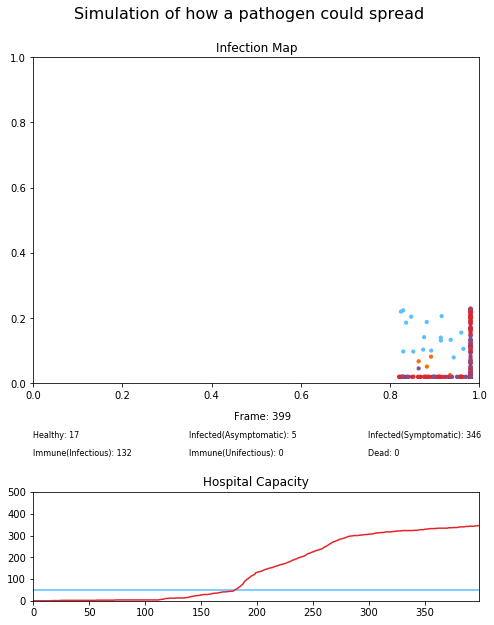

In [19]:
class Simulation():
    
    def __init__(self, *args, **kwargs):
        self.initialize_parameters()
        self.initialize_population()
        self.initialize_movementstream()
        
        self.setup_fig()
        self.setup_ax1()
        self.setup_ax1scatter()
        self.setup_ax2()
        self.setup_ax3()
        
        self.create_animation()
        
        self.checkpoint = dt.datetime.now()
        
    def initialize_parameters(self):
        self.params = Params()
    
    def initialize_population(self):
        self.population = initialize(self.params)
        
    def initialize_movementstream(self):
        self.stream = self.movement_stream()
    
    def setup_fig(self):
        self.fig = plt.figure(figsize=(8,10))
        self.fig.suptitle('Simulation of how a pathogen could spread', y=0.95, fontsize=16)
        self.grid = plt.GridSpec(8, 6, hspace=1)
    
    def setup_ax1(self):
        self.ax1 = self.fig.add_subplot(self.grid[:5,:])
        self.ax1.set_title('Infection Map', fontdict={'fontsize':12, 'color': 'black'})
        self.ax1.set_xlim((self.params.x_min, self.params.x_max))
        self.ax1.set_ylim((self.params.y_min, self.params.y_max))
    
    def setup_ax1scatter(self):
        self.scat = self.ax1.scatter(x = self.population["current_x"], 
                                    y = self.population["current_y"], 
                                    s = 10, c = self.population["state_color"])
    
    def setup_ax2(self):
        self.ax2 = self.fig.add_subplot(self.grid[5:6,:])
        self.text_frames = self.ax2.text(0.45, 1, "", fontsize=10)
        self.text_healthy = self.ax2.text(0, 0.5, "", fontsize=8)
        self.text_infected_a = self.ax2.text(0.35, 0.5, "", fontsize=8)
        self.text_infected_s = self.ax2.text(0.75, 0.5, "", fontsize=8)
        self.text_immune_i = self.ax2.text(0, 0, "", fontsize=8)
        self.text_immune_u = self.ax2.text(0.35, 0, "", fontsize=8)
        self.text_dead = self.ax2.text(0.75, 0, "", fontsize=8)
        self.ax2.set_axis_off()
    
    def update_ax2_stats(self, frame):
        self.healthy = self.population[self.population["state"] == 0]
        self.infected_a = self.population[self.population["state"] == 1]
        self.infected_s = self.population[self.population["state"] == 2]
        self.immune_i = self.population[self.population["state"] == 3]
        self.immune_u = self.population[self.population["state"] == 4]
        self.dead = self.population[self.population["state"] == 5]
        self.text_frames.set_text(f'Frame: {frame}')
        self.text_healthy.set_text(f'Healthy: {len(self.healthy)}')
        self.text_infected_a.set_text(f'Infected(Asymptomatic): {len(self.infected_a)}')
        self.text_infected_s.set_text(f'Infected(Symptomatic): {len(self.infected_s)}')
        self.text_immune_i.set_text(f'Immune(Infectious): {len(self.immune_i)}')
        self.text_immune_u.set_text(f'Immune(Unifectious): {len(self.immune_u)}')
        self.text_dead.set_text(f'Dead: {len(self.dead)}')
    
    def setup_ax3(self):
        self.ax3 = self.fig.add_subplot(self.grid[6:,:])
        self.ax3.set_title('Hospital Capacity', fontdict={'fontsize':12, 'color': 'black'})
        self.ax3.set_xlim((0, 20))
        self.ax3.set_ylim((0, self.params.pop_size))
        self.ax3.axhline(y=self.params.hospital_capacity, c="#59BFFF")
        self.tracking_infections, = self.ax3.plot([], [], c="#E3242B")
        self.running_frames = []
        self.running_infected = []
    
    def update_ax3_chart(self, i):
        if (i > 20):
            self.ax3.set_xlim((0, i))
        self.running_frames.append(i)
        self.running_infected.append(len(self.population[self.population["state"] == 2]))
        self.tracking_infections.set_xdata(self.running_frames)
        self.tracking_infections.set_ydata(self.running_infected)
    
    def create_animation(self):
        self.ani = animation.FuncAnimation(self.fig, self.next_frame, 
                                           frames = self.params.num_of_frames, 
                                           interval = 20, blit = True)

    def movement_stream(self):
        while True:
            speed = np.random.randint(1, 10, self.params.pop_size)
            x_delta = np.clip(np.round(np.random.normal(0, 0.005, self.params.pop_size), 5), -0.01, 0.01).reshape(self.params.pop_size,1)
            y_delta = np.clip(np.round(np.random.normal(0, 0.005, self.params.pop_size), 5), -0.01, 0.001).reshape(self.params.pop_size,1)
            xy_delta = np.hstack([x_delta, y_delta])
            yield xy_delta
    
    def take_step(self):
        xy_delta = next(self.stream)
        # Increment the current position
        xy_pos = np.hstack([np.array(self.population["current_x"]).reshape(self.params.pop_size,1), 
                            np.array(self.population["current_y"]).reshape(self.params.pop_size,1)])
        xy_new_pos = xy_pos + xy_delta
        # Keep the positions of the population within the x and y bounds
        xy_new_pos[:, 0] = np.clip(xy_new_pos[:, 0], self.params.x_min_bound, self.params.x_max_bound)
        xy_new_pos[:, 1] = np.clip(xy_new_pos[:, 1], self.params.y_min_bound, self.params.y_max_bound)
        # Update the positions within the dataframe
        self.population["current_x"] = np.clip(xy_new_pos[:, 0], self.params.x_min_bound, self.params.x_max_bound)
        self.population["current_y"] = np.clip(xy_new_pos[:, 1], self.params.y_min_bound, self.params.y_max_bound)
        
        return xy_new_pos
    
    def next_frame(self, i):
        # Increment "frames_since_infected" for infected population
        self.population.loc[self.population["state"]==1, ["frames_since_infected"]] += 1
        # Determine outcomes during the incubation period
        self.population = incubation_determination(self.population, self.params)
        # Infect someone at frame 1
        if (i == 1):
            self.population.at[i, "state"] = 1
            self.population.at[i, "state_color"] = self.params.colors[1]
        # Infect new people
        for each_state in [1,2,3]:
            self.population = infect(self.population, self.params, each_state)
        # Move the population
        self.new_pos = self.take_step()
        self.scat.set_offsets(self.new_pos)
        # Update ax2 stats and the ax3 chart
        self.update_ax2_stats(i)
        self.update_ax3_chart(i)
        # Set the population color to visually show the state
        self.scat.set_color(self.population["state_color"])
        #self.fig.canvas.draw()
        self.monitor_execution(i)
        
        return self.scat,
    
    def monitor_execution(self, i):
        # Keep track of the speed of execution every 25 frames
        if (i >= 25 and i % 25 == 0):
            print("Frame", i)
            self.get_time(i)
            self.checkpoint = dt.datetime.now()
        # Time taken between the last checkpoint and the final frame
        if (i == self.params.num_of_frames - 1):
            self.end_time()
    
    def get_time(self, i):
        interim_time = dt.datetime.now()
        simulation_interim_time = (interim_time - self.checkpoint) * 1000
        print(f"Frames {i - 25} to {i} took {simulation_interim_time.total_seconds()} milliseconds")
        
    def end_time(self):
        print("Ending simulation")
        end_simulation = dt.datetime.now()
        simulation_final_interim = (end_simulation - self.checkpoint) * 1000
        simulation_time = (end_simulation - begin_simulation) * 1000
        
        print("Last set of frames took", simulation_final_interim.total_seconds())
        print("Total time", simulation_time.total_seconds())

if __name__ == '__main__':
    begin_simulation = dt.datetime.now()
    a = Simulation()
    HTML(a.ani.to_html5_video())

In [20]:
HTML(a.ani.to_html5_video())